In [53]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta
import os
from newsapi.newsapi_client import NewsApiClient
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas

In [54]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [55]:
# Set the tickers
tickers = ["AAPL", "AMZN", "GOOGL", "NFLX"]

# Set timeframe to '1D'
timeframe = '1D'

# Get current date and the date from one year ago
current_date = date.today()
past_date = date.today() - timedelta(weeks=52)

df = pd.DataFrame()

# Get historical data
for tick in tickers:
    tmp_df = api.get_barset(
        tick,
        timeframe,
        limit=365,
        start=current_date,
        end=past_date,
        after=None,
        until=None,
    ).df
    tmp_df = tmp_df.droplevel(0, axis=1)
    tmp_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    tmp_df.rename({'close': tick}, axis=1, inplace=True)
    df = pd.concat([df, tmp_df], axis=1)

df.head()

,AAPL,AMZN,GOOGL,NFLX
time,,,,
2019-01-16 00:00:00-05:00,154.9100,1681.9703,1088.210,350.7639
2019-01-17 00:00:00-05:00,155.5300,1691.3700,1098.150,353.8200
2019-01-18 00:00:00-05:00,156.5700,1693.2421,1105.400,338.9200
2019-01-22 00:00:00-05:00,152.9300,1628.3980,1074.540,324.5401
2019-01-23 00:00:00-05:00,153.6799,1636.5500,1082.815,321.5900


In [56]:
# combine all closing prices from portfolio into one portfolio value
aapl1_df = df.loc[:,'AAPL'].to_frame()
aapl1_df.rename(columns={'AAPL': 'close'}, inplace=True)
aapl1_df.dropna(inplace=True)

nflx1_df = df.loc[:, 'NFLX'].to_frame()
nflx1_df.rename(columns={'NFLX': 'close'}, inplace=True)
nflx1_df.dropna(inplace=True)

googl1_df = df.loc[:,'GOOGL'].to_frame()
googl1_df.rename(columns={'GOOGL': 'close'}, inplace=True)
googl1_df.dropna(inplace=True)

amzn1_df = df.loc[:, 'AMZN'].to_frame()
amzn1_df.rename(columns={'AMZN': 'close'}, inplace=True)
amzn1_df.dropna(inplace=True)

combo_df = aapl1_df["close"] + amzn1_df["close"] + nflx1_df["close"] + googl1_df["close"]
column_names=["close"]
combo_df1 = pd.DataFrame(combo_df,columns = column_names)
combo_df1.head()

,close
time,
2019-01-16 00:00:00-05:00,3275.8542
2019-01-17 00:00:00-05:00,3298.8700
2019-01-18 00:00:00-05:00,3294.1321
2019-01-22 00:00:00-05:00,3180.4081
2019-01-23 00:00:00-05:00,3194.6349


In [57]:
combo_df.hvplot(subplots=True, figsize=(12,8))

:Curve   [time]   (close)

In [58]:
combo_df1["return"] = combo_df1.pct_change()
combo_df1.dropna(inplace=True)

combo_df1['lag_1_day'] = combo_df1['close'].shift()
combo_df1.dropna(inplace=True)

combo_df1.head()

,close,return,lag_1_day
time,,,
2019-01-18 00:00:00-05:00,3294.1321,-0.001436,3298.8700
2019-01-22 00:00:00-05:00,3180.4081,-0.034523,3294.1321
2019-01-23 00:00:00-05:00,3194.6349,0.004473,3180.4081
2019-01-24 00:00:00-05:00,3218.7731,0.007556,3194.6349
2019-01-25 00:00:00-05:00,3263.4100,0.013868,3218.7731


In [59]:
short_window = 20
long_window = 100

# Exponentially weighted moving average
combo_df1["short_window_ma"] = combo_df1["close"].ewm(halflife=short_window).mean()
combo_df["long_window_ma"] = combo_df1["close"].ewm(halflife=long_window).mean()

# Expoentially weighted volatility
combo_df1["fast_vol"] = combo_df1["return"].ewm(halflife=short_window).std()
combo_df1["slow_vol"] = combo_df1["return"].ewm(halflife=long_window).std()

In [60]:
combo_df1.dropna(inplace=True)
combo_df1copy = combo_df1.copy()
combo_df1.head()

,close,return,lag_1_day,short_window_ma,fast_vol,slow_vol
time,,,,,,
2019-01-22 00:00:00-05:00,3180.4081,-0.034523,3294.1321,3236.284855,0.023396,0.023396
2019-01-23 00:00:00-05:00,3194.6349,0.004473,3180.4081,3221.917696,0.021078,0.021029
2019-01-24 00:00:00-05:00,3218.7731,0.007556,3194.6349,3221.090218,0.019355,0.019383
2019-01-25 00:00:00-05:00,3263.4100,0.013868,3218.7731,3230.150775,0.018883,0.018973
2019-01-28 00:00:00-05:00,3207.8557,-0.017023,3263.4100,3226.105706,0.017977,0.018043


In [61]:
X = combo_df1.drop(columns=['lag_1_day'])
y = combo_df1.lag_1_day.values.reshape(-1, 1)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.20)



In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [64]:
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)


In [65]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)

In [66]:
gbr.fit(X_train_scaled, y_train)


/opt/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

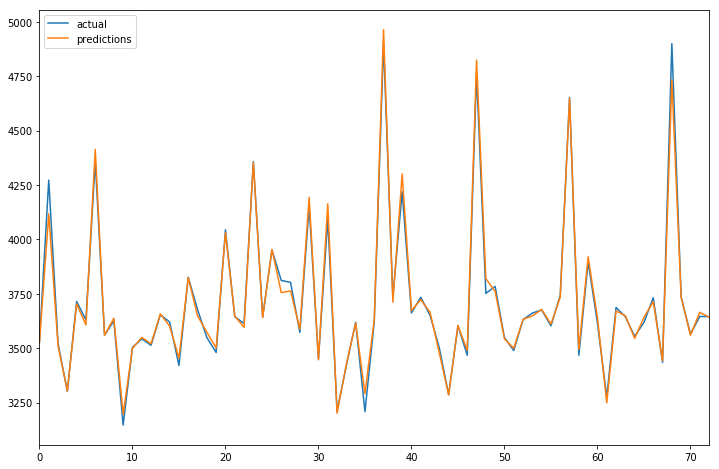

In [67]:
GBR_predictions = gbr.predict(X_test_scaled)

GBR_predictions_df = pd.DataFrame({'actual': np.ravel(y_test), 'predictions': GBR_predictions})

GBR_predictions_df.plot(figsize=(12,8))

In [68]:
from sklearn.metrics import mean_squared_error

In [69]:
GBR_MSE = mean_squared_error(y_test, GBR_predictions)

print(f"GBR MSE: {GBR_MSE}")

GBR MSE: 1471.2025008072335


In [70]:
np.sqrt(GBR_MSE)

38.35625764861887

In [74]:
gbr.score(X_test, y_test)

-12.936113296888191